In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import numpy as np


In [2]:
# This script takes files as input and generates images. 
# The filenames in the input commands and the name of the resource need to be configured. 

In [3]:
# Define a function that can check to see if any of the reference types are not present, e.g.  no in-text references were found for a particular resource
def f(a,b):
    if len(b) == 2:
        for j in "A","C","T":
            if len(pd.value_counts(a['Reference-Code']==j)) == 1:
                b[j]=0


In [4]:
def Bar_Plot(df_name,df_ID,Resource,Name_Plot_Num,ID_Plot_Num):
    # The four data series of interest are pulled out separately
    # Primary literature vs grey literature and references to the resource by name vs by the resources ID 
    Primary_name = df_name[df_name['Paper-Type']=="P"]
    Grey_name = df_name[df_name['Paper-Type']=="G"]

    Primary_ID = df_ID[df_ID['Paper-Type']=="P"]
    Grey_ID = df_ID[df_ID['Paper-Type']=="G"]

    # Compile the counts for each reference type: Citation, Acknowledgement, and In-text reference
    Primary_name_ref_count = pd.value_counts(Primary_name['Reference-Code'])
    Grey_name_ref_count = pd.value_counts(Grey_name['Reference-Code'])

    Primary_ID_ref_count = pd.value_counts(Primary_ID['Reference-Code'])
    Grey_ID_ref_count = pd.value_counts(Grey_ID['Reference-Code'])

    # Apply the function to each data series to standardize the data structure
    f(Grey_ID,Grey_ID_ref_count)
    f(Grey_name,Grey_name_ref_count)
    f(Primary_ID,Primary_ID_ref_count)
    f(Primary_name,Primary_name_ref_count)

    # Reindex each series to ensure that they are all in the same order
    Grey_ID_ref_count = Grey_ID_ref_count.reindex(index = ["C","A","T"])
    Primary_ID_ref_count = Primary_ID_ref_count.reindex(index = ["C","A","T"])
    Grey_name_ref_count = Grey_name_ref_count.reindex(index = ["C","A","T"])
    Primary_name_ref_count = Primary_name_ref_count.reindex(index = ["C","A","T"])


    # Generate a bar chart for the documents that reference the resource by name
    plt.figure(1)

    aa = plt.subplot(420 + Name_Plot_Num)
    P_I = plt.bar([1,4,7], Primary_ID_ref_count, align='center', alpha=0.5, color='b')
    G_I = plt.bar([2,5,8], Grey_ID_ref_count, align='center', alpha=0.5, color='r')
    plt.xticks([1.5,4.5,7.5], ['Citations','Acknowledgements','In-Text only'], fontsize=6)
    plt.yticks(fontsize=6)
    plt.ylabel(Resource + "\nDocs.")


    # Generate a bar chart for the documents that reference the resource by ID
    plt.subplot(420 + ID_Plot_Num, sharey=aa)
    P_N = plt.bar([1,4,7], Primary_name_ref_count, align='center', alpha=0.5, color='b')
    G_N = plt.bar([2,5,8], Grey_name_ref_count, align='center', alpha=0.5, color='r')
    plt.xticks([1.5,4.5,7.5], ['Citations','Acknowledgements','In-Text only'], fontsize=6)
    plt.yticks(fontsize=6)
    plt.subplots_adjust(wspace = .2, hspace = .25)
    


In [5]:
Yellow_df_name = pd.read_csv('../data/Yellowstone-Name-Refs.csv')
Yellow_df_ID = pd.read_csv('../data/Yellowstone-ARK-Refs.csv')
#Resource = "Yellowstone-SC"

NCL_df_name = pd.read_csv('../data/NCL-Name-Refs.csv')
NCL_df_ID = pd.read_csv('../data/NCL-DOI-Refs.csv')
#Resource = "NCL-Software"

NCEP_df_name = pd.read_csv('../data/NCEP-Name-Refs.csv')
NCEP_df_ID = pd.read_csv('../data/NCEP-DOI-Refs.csv')
#Resource = "NCEP-Data"

NARCCAP_df_name = pd.read_csv('../data/NARCCAP-Name-Refs.csv')
NARCCAP_df_ID = pd.read_csv('../data/NARCCAP-DOI-Refs.csv')
#Resource = "NARCCAP-Data"

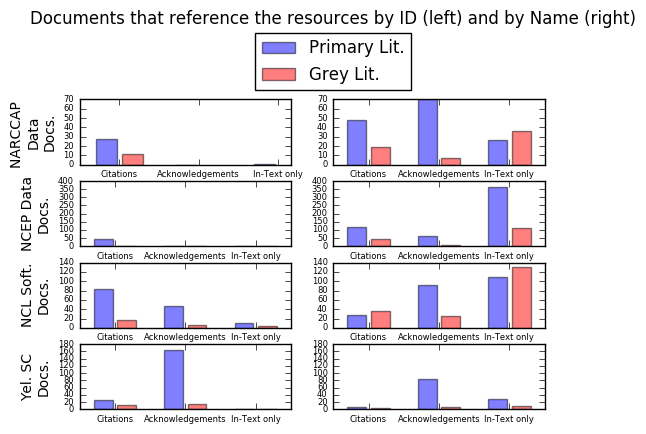

In [6]:
Bar_Plot(NARCCAP_df_name,NARCCAP_df_ID,"NARCCAP \nData",1,2)
plt.title('Documents that reference the resources by ID (left) and by Name (right)',position = [0, 2.05])
plt.legend(["Primary Lit.","Grey Lit."],bbox_to_anchor=(0, 2.15), loc='upper center')
Bar_Plot(NCEP_df_name,NCEP_df_ID,"NCEP Data",3,4)
Bar_Plot(NCL_df_name,NCL_df_ID,"NCL Soft.",5,6)
Bar_Plot(Yellow_df_name,Yellow_df_ID,"Yel. SC",7,8)
plt.savefig('Fig1.tif', bbox_inches='tight', dpi=300)

In [7]:
def Timeline_Plot(df_name,df_ID,Resource,Key_loc,Fig_num):
    # Create an dictionary and compile the counts of publications in each year for the two categories of primary literature references
    # In the dictionary, the publications that reference the resource by Name come first, then the publications that reference the resource by its ID
    Primary_name = df_name[df_name['Paper-Type']=="P"]
    Primary_ID = df_ID[df_ID['Paper-Type']=="P"]
   
    Pub_Years = {}

    # Compile the data
    for d in Primary_name['Pub-Date']:
        date_info = re.split('-',d)
        year = date_info[0]
        if (year in Pub_Years) == False:
            Pub_Years[year] = [1,0]
        else:    
            Pub_Years[year][0] += 1

    for d in Primary_ID['Pub-Date']:
        date_info = re.split('-',d)
        year = date_info[0]
        if (year in Pub_Years) == False:
            Pub_Years[year] = [0,1]
        else:    
            Pub_Years[year][1] += 1     

    # Remove the articles from 2016 because there is not a complete year's worth of results.
    if "2016" in Pub_Years:
        del Pub_Years["2016"]

    # Generate two lists of data for plotting
    Name_stack = []
    ID_stack = []
    for i in sorted(Pub_Years):
        Name_stack.append(Pub_Years[i][0])
        ID_stack.append(Pub_Years[i][1])


    # Create the timeseries plot
    N = len(Pub_Years) # the number of years in the plot
    ind = np.arange(N) # the x locations for the groups
    width = .5    # the width of the bars

    fig, ax = plt.subplots()

    p1 = plt.bar(ind, Name_stack, width, color='black')
    p2 = plt.bar(ind, ID_stack, width, color='y', bottom=Name_stack)

    plt.ylabel('Documents')
    plt.title(Resource + ' - Primary Literature References Per Year')
    if Resource == "NCL Software":
        plt.xticks(ind[0::2] + width/2., [i for i in (sorted(Pub_Years))[0::2]]) #this line was used for the NCL plot because the x labels were overlapping each other
    else:
        plt.xticks(ind + width/2., [i for i in sorted(Pub_Years)])
    ax.set_xlim([0, N])
    plt.legend((p1[0], p2[0]), ('References by Name', 'References by ID'), loc=Key_loc)
    plt.savefig("Fig" + Fig_num + '.tif', dpi=300)
    plt.show()

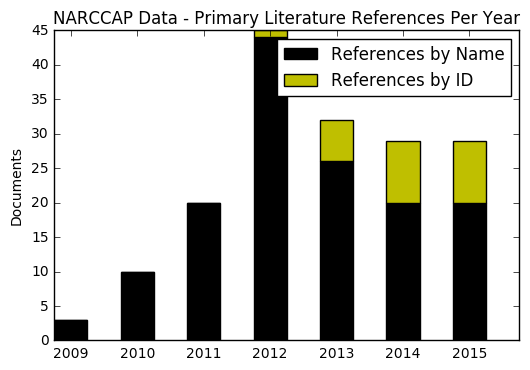

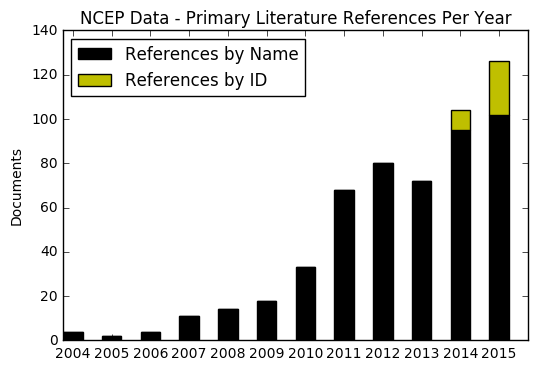

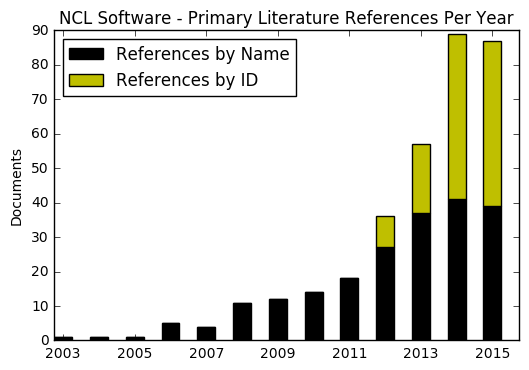

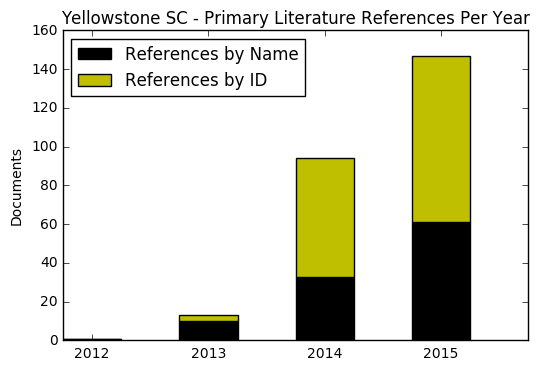

In [8]:
Timeline_Plot(NARCCAP_df_name,NARCCAP_df_ID,"NARCCAP Data",1,"2")
Timeline_Plot(NCEP_df_name,NCEP_df_ID,"NCEP Data",2,"3")
Timeline_Plot(NCL_df_name,NCL_df_ID,"NCL Software",2,"4")
Timeline_Plot(Yellow_df_name,Yellow_df_ID,"Yellowstone SC",2,"5")


In [9]:
'''
    This helper function is used to obtain a clean version of the df with percentage distributions of values.
'''
def df_get_pct_dist(df_name, df_ID, Resource):
    import collections
    import math

    # clean up the dataframe dates
    df_ID['Pub-Date'] = pd.to_datetime(df_ID['Pub-Date'], infer_datetime_format=True, errors="coerce")
    df_name['Pub-Date'] = pd.to_datetime(df_name['Pub-Date'], infer_datetime_format=True, errors="coerce")
    
    # update the datasets in preparation for storage
    y_by_id   = Counter([y[1].year for y in df_ID['Pub-Date'].iteritems() if not math.isnan(y[1].year)])
    y_by_name = Counter([y[1].year for y in df_name['Pub-Date'].iteritems() if not math.isnan(y[1].year)])

    # filter out 2016 and NaN data
    pub_years = set(y_by_id.keys() + y_by_name.keys()) - {2016, float('NaN')}
    
    # store the pct counts in the dictionary
    y_pct_count = { str(y): \
                       {'raw': (y_by_id[y]+y_by_name[y], y_by_id[y], y_by_name[y]),
                        '% Reference by ID': 100.*(y_by_id[y]*1./(y_by_name[y]+y_by_id[y])),
                        '% Reference by Name': 100.*(y_by_name[y]*1./(y_by_name[y]+y_by_id[y]))} 
                    for y in pub_years }

    return pd.DataFrame \
                .from_dict(y_pct_count, 'index') \
                .drop('raw', 1) 

In [10]:
'''
    Function to print and save the line plot given a dataframe
'''
def LinePctPlot(df_name, df_ID, Resource, Fig_num):   
    import collections
    import math

    lnplt = df_get_pct_dist(df_name, df_ID, Resource) \
                 .plot(marker='o', colormap='gnuplot', style=['--', '-'], \
                       title='{} - Primary Literature References Per Year'.format(Resource))
        
    lnplt.set_ylabel('Percent total references')
    lnplt.set_xlabel('Year')
    
    plt.savefig("../images/Fig"+ Fig_num +"_line_plot.tif", dpi=300)
    plt.savefig("../images/Fig"+ Fig_num +"_line_plot.png", dpi=300)

In [11]:
'''
    Function to make a 4up plot manually tweaked.
'''
def FourUpPctPlot(data):
    from numpy import arange
    fig, axes = plt.subplots(nrows=2, ncols=2)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.175)
    
    for i, d in enumerate(data):
        ax  = df_get_pct_dist(*d[:3])

        if i < 2:
            subplt = ax.plot(ax=axes[i/2, i], marker='o', \
                             colormap='gnuplot', style=['--', '-'], \
                             xticks=arange(len(ax.index)), fontsize=5, \
                             markersize=4)
        else:
            subplt = ax.plot(ax=axes[i/2, i%2], marker='o', \
                             colormap='gnuplot', style=['--', '-'], \
                             xticks=arange(len(ax.index)), fontsize=5, \
                             markersize=4)    
            subplt.set_xlabel('Year', fontsize=8)

        # title
        subplt.set_title('{} - \nPrimary Literature References Per Year'.format(d[2]), fontsize=8)
        
        # legend
        subplt.legend(loc='best', prop={'size': 6}, markerscale=0.5)
        
        #  y labels only needed 1x per row 
        if i%2 == 0:            
            subplt.set_ylabel('Percent total references', fontsize=8)
                                 
    plt.savefig("../images/Fig4up_line_plot.png", dpi=600)
    plt.savefig("../images/Fig4up_line_plot.tif", dpi=600)

In [12]:
fig4up_data = [
                (NARCCAP_df_name, NARCCAP_df_ID, "NARCCAP Data", "2"),
                (NCEP_df_name, NCEP_df_ID, "NCEP Data", "3"),
                (NCL_df_name, NCL_df_ID, "NCL Software", "4"),
                (Yellow_df_name, Yellow_df_ID, "Yellowstone SC", "5")
              ]

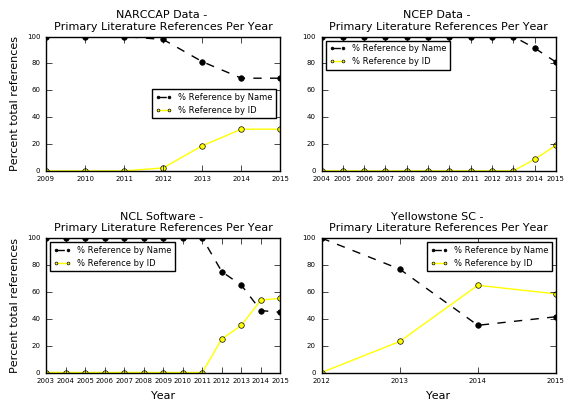

In [13]:
FourUpPctPlot(fig4up_data)

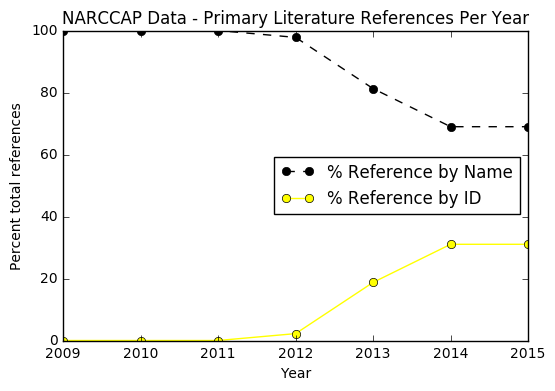

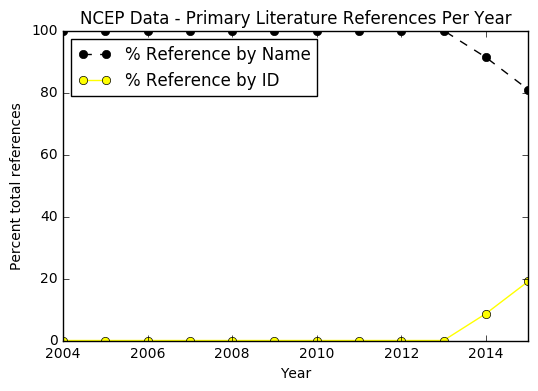

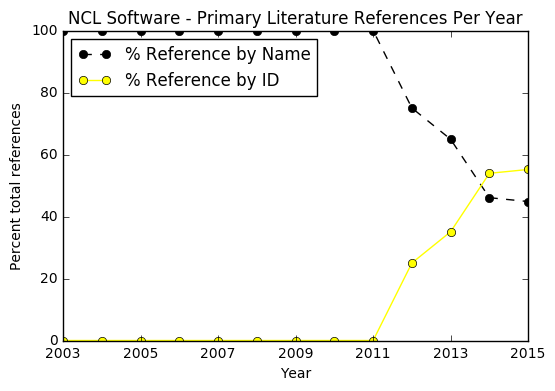

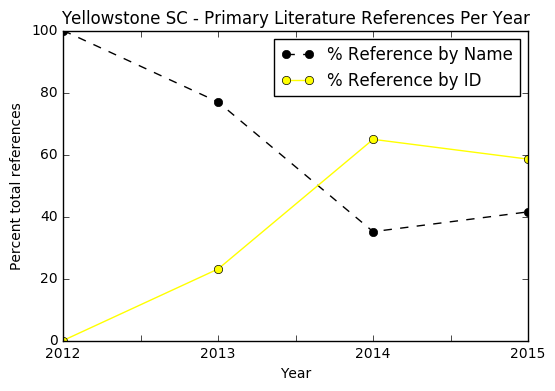

In [14]:
for f in fig4up_data:
    LinePctPlot(*f)